Presented by: Reza Saadatyar 2022-2023<br/>
E-mail: Reza.Saadatyar92@gmail.com<br/>
[Link](https://github.com/RezaSaadatyar/Deep-Learning-in-python)

**Types of Recurrent Neural Networks**<br/>
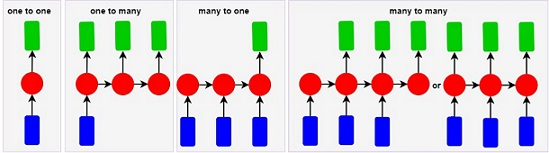   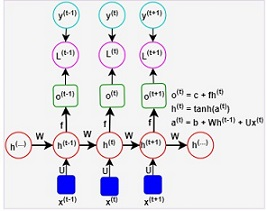

==================================== Importing Libraries =================================

In [95]:
import os
import sys
import math
import gluonts 
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras import models, optimizers 
from gluonts.dataset.util import to_pandas
# from gluonts.dataset.common import ListDataset
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, SimpleRNN, LSTM, GRU

# from gluonts.mx import DeepAREstimator
# from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
# from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestMean
# from gluonts.mx.trainer import Trainer
# from gluonts.evaluation import make_evaluation_predictions

========================================= Functions ==================================

In [132]:
# =============================================== Preparing data =====================================================
def Prepare_data(data):  
     # -------------------------------------------- Step 1.1: Check type data ----------------------------------------     
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    return data

# ============================================= Sequences data =======================================================
def sequences_data(data, x_steps=6, y_steps=2, train_size=0.7, nfeatures=1):
    # !============================================= Step 1: Split data ==============================================
    # -------------------------------------------- Step 1.1: Check type data -----------------------------------------    
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # --------------------------------------------- Step 1.3: Data Splitting -----------------------------------------   
    n = math.floor(data.shape[0] * train_size)
    dat_train = data.iloc[0:n,:]
    data_train = dat_train.values.reshape(-1,1)
    
    dat_test = data.iloc[data_train.shape[0]-x_steps:,:]
    data_test = dat_test.values.reshape(-1,1)
    # !============================================== Step 2: Scaling ================================================
    mod = MinMaxScaler(feature_range=(0, 1))
    data_train = mod.fit_transform(data_train)
    data_test = mod.transform(data_test)
    # !============================================== Step 3: Sequences ==============================================
    # --------------------------------------------- Step 3.1: Sequences x_train --------------------------------------
    x_train = []
    y_train = []
    for i in range(x_steps, len(data_train)-y_steps+1):
        x_train.append(data_train[i-x_steps:i, 0])
        y_train.append(data_train[i:i+y_steps, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], nfeatures))
    # -------------------------------------------- Step 3.2: Sequences x_test ----------------------------------------
    x_test = []
    y_test = []
    for i in range(x_steps, len(data.iloc[n:,:])+x_steps-y_steps+1):
        x_test.append(data_test[i-x_steps:i, 0])
        y_test.append(data_test[i:i+y_steps, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, dat_train, dat_test, mod

# ============================================= Plot prediction ======================================================
def plot_prediction(data_train, data_test, pred_train, pred_test, mod):
    
    _, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(8, 3))
    # axs[0].plot(data.iloc[0:pred_train.shape[0],:], label='Train data')
    axs[0].plot(data_train, label='Train data')
    axs[0].plot(data_train.index[:pred_train.shape[0]], mod.inverse_transform(pred_train[:,0].reshape(-1,1)), label='Estimate')
    axs[0].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[1].plot(data_test, label='Test data')
    axs[1].plot(data_test.index[:pred_test.shape[0]:], mod.inverse_transform(pred_test[:,0].reshape(-1,1)), label='Estimate')
    axs[1].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[0].autoscale(enable=True, axis="x",tight=True)
    axs[1].autoscale(enable=True, axis="x",tight=True)
    plt.subplots_adjust(wspace=0.04, hspace=0.2)
    
# ====================================== Plot loss for train & test ==================================================   
def plot_loss(train_model, axs, title=None):
    # _, axs = plt.subplots(nrows=1, sharey='row', figsize=(4, 3))
    axs.plot(train_model.history["loss"], label='training loss')
    axs.plot(train_model.history["val_loss"], label='validation loss',)
    axs.legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)
    axs.autoscale(enable=True, axis="x",tight=True)
    axs.set_xlabel('Epochs', fontsize=10)
    axs.set_title(title, fontsize=10)

*Step 1.1: Load Data*

In [99]:
data = sm.datasets.sunspots.load_pandas()  
data = data.data["SUNACTIVITY"]

In [100]:
data = Prepare_data(data)
print(f"{data = }")

data =      SUNACTIVITY
0            5.0
1           11.0
2           16.0
3           23.0
4           36.0
..           ...
304         40.4
305         29.8
306         15.2
307          7.5
308          2.9

[309 rows x 1 columns]


*Step 1.2: Plot data*

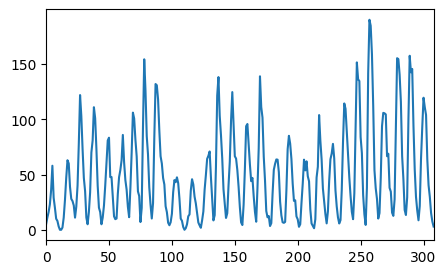

In [101]:
_, axs = plt.subplots(nrows=1,sharey='row', figsize=(5,3))
axs.plot(data)
axs.set_xlabel('', fontsize=10)
axs.set_title(f"", fontsize=10)
axs.set_ylabel('', fontsize=10)
axs.autoscale(enable=True, axis="x",tight=True)

*Step 2: Creating sequences*

In [102]:
x_steps = 6
y_steps = 2
x_train, y_train, x_test, y_test, data_train, data_test, mod = sequences_data(data, x_steps, y_steps, train_size=0.6, nfeatures=1)

*Step 3: Creating the Simple [RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) Model using:*<br/>
[Sequential model](https://keras.io/guides/sequential_model/)<br/>
[Dense layer](https://keras.io/api/layers/core_layers/dense/)<br/>
[Activation functions](https://keras.io/api/layers/activations/)<br/>
[Model compile](https://keras.io/api/models/model_training_apis/)<br/>
[Metrics](https://keras.io/api/metrics/regression_metrics/)<br/>
[Fit method](https://keras.io/api/models/model_training_apis/)

*inputs $\Rightarrow$ Preparing 3-Dimensional Input for Sequential Model, with shape [batch, timesteps, feature].*<br/>

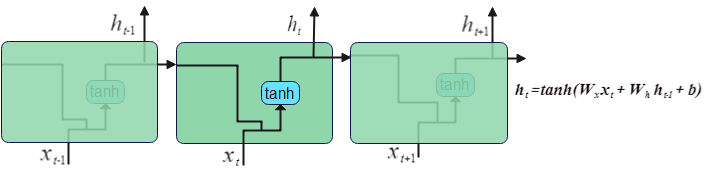

**Disadvantages of RNNs:**<Br/>
The RNN has issues with *`vanishing gradient descent`*, where the gradients used to update weights become very small and prevent the network from learning new weights. This problem worsens with more layers. Also, RNNs tend to lose information over long sequences as they only store the latest information, resulting in a short-term memory and not a long-term memory. Moreover, as the RNN uses backpropagation in time to update weights, the network also suffers from *`exploding gradients`* and, if ReLu activation functions are used, from dead ReLu units. The first might lead to convergence issues while the latter might stop the learn

In [103]:
# ================================================= Step 3.1: Building the network =================================================
methods = "Method 1"
if methods == "Method 1":                                                       # define model
    rnn_model = models.Sequential([SimpleRNN(50, return_sequences=True),                      
                                SimpleRNN(50),
                                Dense(y_steps)])
else:
    rnn_model = models.Sequential()                                             # define model
    rnn_model.add(SimpleRNN(50, dropout=0.2, return_sequences=True, 
                            input_shape=(x_train.shape[1], x_train.shape[2])))  # input_shape-->(n_timesteps,n_feature)
    rnn_model.add(SimpleRNN(50, dropout=0.2, activation="tanh", return_sequences=True))
    rnn_model.add(SimpleRNN(50, dropout=0.2, activation="sigmoid", return_sequences=True))
    rnn_model.add(SimpleRNN(40, dropout=0.3, activation="tanh"))
    rnn_model.add(Dense(y_train.shape[1]))                                      # n_outputs-->y_train.shape[1]
    print(f"rnn_model.summary:")
    print(f"{rnn_model.summary()}")
    
print(f"\nrnn_model.layers:\n{rnn_model.layers}")                               # Print the model parameters
# ?==================================================== Step 3.2: Compile model =====================================================
rnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", 
                  metrics=["mean_absolute_error"])                              # Regression:mean_squared_error
# !================================================= Step 3.3: Training the Model ===================================================
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
rnn_train_model = rnn_model.fit(x_train, y_train, epochs=100, validation_split=0.15, callbacks=[stop_early])
# train_model = rnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early])
# =========================================== Step 3.4: Predicting for train & test data ===========================================
rnn_pred_train = rnn_model.predict(x_train)
rnn_pred_test = rnn_model.predict(x_test)


rnn_model.layers:
[<keras.src.layers.rnn.simple_rnn.SimpleRNN object at 0x0000027C6FA597D0>, <keras.src.layers.rnn.simple_rnn.SimpleRNN object at 0x0000027C6FAA51D0>, <keras.src.layers.core.dense.Dense object at 0x0000027C71009CD0>]
Epoch 1/100
5/5 [==============================] - 5s 130ms/step - loss: 0.1998 - mean_absolute_error: 0.3167 - val_loss: 0.1804 - val_mean_absolute_error: 0.2975
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 0.1247 - mean_absolute_error: 0.2468 - val_loss: 0.0597 - val_mean_absolute_error: 0.1815
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0483 - mean_absolute_error: 0.1599 - val_loss: 0.0683 - val_mean_absolute_error: 0.1842
Epoch 4/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0512 - mean_absolute_error: 0.1615 - val_loss: 0.0408 - val_mean_absolute_error: 0.1473
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0356 - mean_absolute_error: 0.1463 - val_lo

*Long-Short-Term-Memory [(LSTM)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)*<br/>
LSTMs are a type of RNNs that solve the problem of vanishing gradients, which is the loss of information from the distant past, that simple RNNs face.

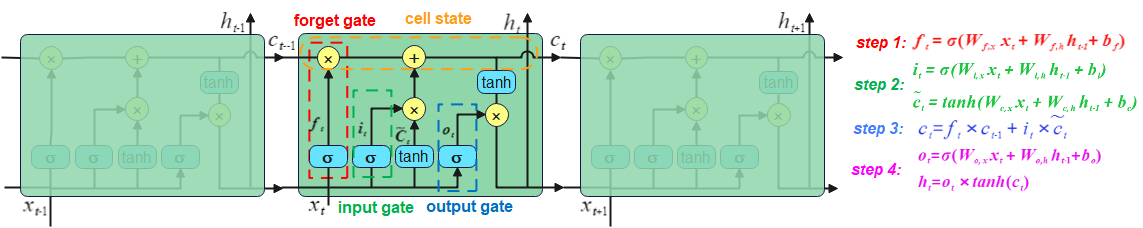

The *`forget gate`*, which utilizes a sigmoid function, determines the relevance of the cell state and determines how much of the long-term memory should be retained.<br/>
The *`input gate`*, through a sigmoid layer, determines the information that will be incorporated into the cell state and consequently the long-term memory.<br/>
The *`output gate`* controls the selection of cell state components that contribute to the output, and therefore, it is responsible for short-term memory.<br/>

**Disadvantages of LSTMs**<br/>
- LSTMs are more computationally intensive, resulting in lengthier training periods.
-  LSTM also uses the backpropagation in time algorithm to update the weights, the LSTM suffers from the disadvantages of the backpropagation (e.g., dead ReLu elements, exploding gradients).

In [106]:
# ================================================= Step 3.1: Building the network =================================================
methods = "Method 1"
if methods == "Method 1":                                                       # define model
    lstm_model = models.Sequential([LSTM(50, return_sequences=True),
                    LSTM(50),
                    Dense(y_steps)])
else:
    lstm_model = models.Sequential()                                            # define model
    lstm_model.add(LSTM(100, return_sequences=True, dropout=0.2, 
                        input_shape=(x_train.shape[1], x_train.shape[2])))      # input_shape-->(n_timesteps,n_feature)
    lstm_model.add(LSTM(70, activation="relu", dropout=0.1, return_sequences=True))
    lstm_model.add(LSTM(100, activation="tanh", dropout=0))
    lstm_model.add(Dense(y_train.shape[1], activation="tanh"))                  # n_outputs-->y_train.shape[1]
    print(f"lstm_model.summary:")
    print(f"{lstm_model.summary()}")
    
print(f"\n lstm_model.layers:\n{lstm_model.layers}")                             # Print the model parameters                                    
# ?==================================================== Step 3.2: Compile model =====================================================
lstm_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", 
                  metrics=["mean_absolute_error"])                              # Regression:mean_squared_error   
# !================================================= Step 3.3: Training the Model ===================================================
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lstm_train_model = lstm_model.fit(x_train, y_train, epochs=100, validation_split=0.15, callbacks=[stop_early])
# train_model = rnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early])
# =========================================== Step 3.4: Predicting for train & test data ===========================================
lstm_pred_train = lstm_model.predict(x_train)
lstm_pred_test = lstm_model.predict(x_test)    


 lstm_model.layers:
[<keras.src.layers.rnn.lstm.LSTM object at 0x0000027C70EC0C50>, <keras.src.layers.rnn.lstm.LSTM object at 0x0000027C70E9C810>, <keras.src.layers.core.dense.Dense object at 0x0000027C70E9B910>]
Epoch 1/100
5/5 [==============================] - 11s 340ms/step - loss: 0.1193 - mean_absolute_error: 0.2582 - val_loss: 0.1207 - val_mean_absolute_error: 0.2725
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0862 - mean_absolute_error: 0.2145 - val_loss: 0.0904 - val_mean_absolute_error: 0.2417
Epoch 3/100
5/5 [==============================] - 0s 52ms/step - loss: 0.0666 - mean_absolute_error: 0.2013 - val_loss: 0.0763 - val_mean_absolute_error: 0.2319
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0650 - mean_absolute_error: 0.2132 - val_loss: 0.0742 - val_mean_absolute_error: 0.2313
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0621 - mean_absolute_error: 0.2087 - val_loss: 0.0693 - val_me

*Gated Recurrent Unit [(GRU)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)*<br/>
[Article](https://arxiv.org/pdf/1406.1078.pdf)<br/>
GRU resolves vanishing gradient issue in basic RNNs. GRUs have a simpler architecture compared to LSTMs as they use fewer gates and do not have a separate internal memory or cell state. Instead, they solely rely on the hidden state as a memory.

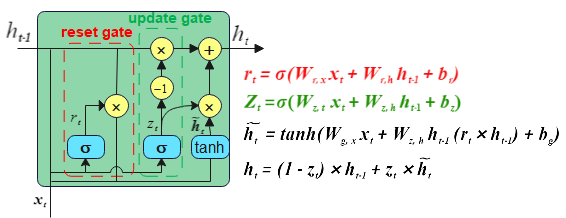

The *`reset gate`* controls short-term memory by determining which past information is retained and which is ignored. The vector *r's* values are limited to a range of *0 to 1* through a *sigmoid function*. These values are determined by the hidden state *h* from the previous time step and the current *input x*.<br/>
The `update gate` is like the LSTM's forget gate but is in charge of long-term memory.

**Disadvantages of GRUs**
- The GRU may not be able to take into account observations from as far back in time as the LSTM due to the absence of a distinct hidden and cell state.
- The GRU may experience issues with backpropagation in time and weight updates, such as dead ReLu elements and exploding gradients.

In [107]:
# ================================================= Step 3.1: Building the network =================================================
methods = "Method 1"
if methods == "Method 1":                                                       # define model
    gru_model = models.Sequential([GRU(50, return_sequences=True),
                    GRU(50),
                    Dense(y_steps)]) 
else:
    gru_model = models.Sequential()                                             # define model
    gru_model.add(GRU(100, return_sequences=True, dropout=0.2, 
                        input_shape=(x_train.shape[1], x_train.shape[2])))      # input_shape-->(n_timesteps,n_feature)
    gru_model.add(GRU(70, activation="tanh", dropout=0.1, return_sequences=True))
    gru_model.add(GRU(100, activation="relu", dropout=0.1))
    gru_model.add(Dense(y_train.shape[1]))                                      # n_outputs-->y_train.shape[1]
    print(f"gru_model.summary:")
    print(f"{gru_model.summary()}")
    
print(f"\n gru_model.layers:\n{gru_model.layers}")                             # Print the model parameters                                    
# ?==================================================== Step 3.2: Compile model =====================================================
gru_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", 
                  metrics=["mean_absolute_error"])                              # Regression:mean_squared_error   
# !================================================= Step 3.3: Training the Model ===================================================
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
gru_train_model = gru_model.fit(x_train, y_train, epochs=100, validation_split=0.15, callbacks=[stop_early])
# train_model = rnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early])
# =========================================== Step 3.4: Predicting for train & test data ===========================================
gru_pred_train = gru_model.predict(x_train)
gru_pred_test = gru_model.predict(x_test)    


 gru_model.layers:
[<keras.src.layers.rnn.gru.GRU object at 0x0000027C66C06F50>, <keras.src.layers.rnn.gru.GRU object at 0x0000027C6667B450>, <keras.src.layers.core.dense.Dense object at 0x0000027C66818B90>]
Epoch 1/100
5/5 [==============================] - 8s 286ms/step - loss: 0.1125 - mean_absolute_error: 0.2485 - val_loss: 0.0935 - val_mean_absolute_error: 0.2415
Epoch 2/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0636 - mean_absolute_error: 0.1912 - val_loss: 0.0653 - val_mean_absolute_error: 0.2132
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0598 - mean_absolute_error: 0.2069 - val_loss: 0.0649 - val_mean_absolute_error: 0.2178
Epoch 4/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0564 - mean_absolute_error: 0.2007 - val_loss: 0.0583 - val_mean_absolute_error: 0.2002
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0515 - mean_absolute_error: 0.1822 - val_loss: 0.0579 - val_mean_abs

*Plot of Training and Test Loss Functions*
[1](https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4)

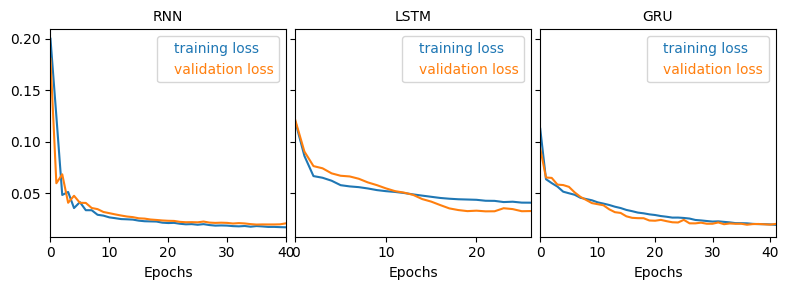

In [136]:
_, axs = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(8, 3))
plot_loss(rnn_train_model, axs[0], title="RNN")
plot_loss(lstm_train_model, axs[1], title="LSTM")
plot_loss(gru_train_model, axs[2], title="GRU")
plt.tight_layout()
plt.subplots_adjust(wspace=0.04, hspace=0.2)


*Plot of actuals and predictions for train & test data*

In [ ]:
plot_prediction(data_train, data_test, pred_train, pred_test, mod)

*[GluonTS](https://www.selvai.com/probabilistic_time_series_modeling.html)*

In [51]:
n = math.floor(data.shape[0] * 0.7)
train_data = ListDataset([{"start":data.index[0], "target":data.iloc[0:n,:]}], freq="H")

GluonTSDataError: Error "day is out of range for month: 0" occurred, when reading field "start"

In [54]:
# from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestMean
from gluonts.mx.trainer import Trainer


ModuleNotFoundError: No module named 'mxnet'

In [39]:
data

,SUNACTIVITY
0,5.0
1,11.0
2,16.0
3,23.0
4,36.0
...,...
304,40.4
305,29.8
306,15.2
307,7.5
